In [4]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset import get_rays
from rendering import rendering
from model import Voxels, Nerf
from ml_helpers import training

In [5]:
test_o, test_d, test_target_px_values = get_rays('fox', mode='test')

In [6]:
device = 'cuda'
tn = 8.
tf = 12.

In [7]:
model = torch.load('model_nerf').to(device)

AssertionError: Torch not compiled with CUDA enabled

In [9]:
400 * 400 * 100

16000000

In [10]:
#so we opt batching fort to fit into gpu memory
400 * 400 * 100 / 1e6

16.0

In [5]:
def mse2psnr(mse):
    return 20 * np.log10(1 / np.sqrt(mse))


@torch.no_grad() #tells pytorch that we will not be computing the gradients so
# it can save memory
def test(model, o, d, tn, tf, nb_bins=100, chunk_size=10, H=400, W=400, target=None):
    # here we use chuck to batch the rendering process into 10 images
    # this is to avoid memory error
    o = o.chunk(chunk_size)
    d = d.chunk(chunk_size)
    
    image = []
    for o_batch, d_batch in zip(o, d): # here we loop through the chunks
        img_batch = rendering(model, o_batch, d_batch, tn, tf, nb_bins=nb_bins, device=o_batch.device)
        image.append(img_batch) # N, 3 # this gives a list of tensors 
    image = torch.cat(image) # so we concatenate them to get a single tensor
    image = image.reshape(H, W, 3).cpu().numpy()
    
    if target is not None:
        mse = ((image - target)**2).mean()
        psnr = mse2psnr(mse)
    
    if target is not None: 
        return image, mse, psnr
    else:
        return image

In [6]:
img, mse, psnr = test(model, torch.from_numpy(test_o[0]).to(device).float(), torch.from_numpy(test_d[0]).to(device).float(),
                tn, tf, nb_bins=100, chunk_size=10, target=test_target_px_values[0].reshape(400, 400, 3))

print(psnr)

28.8992808286121


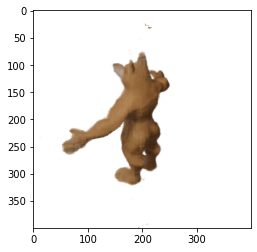

In [7]:
plt.imshow(img) # image from nerf model

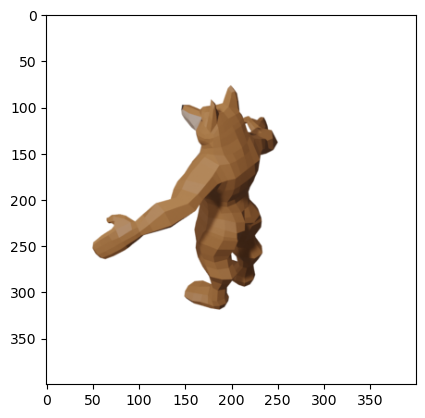

In [13]:
plt.imshow(test_target_px_values[3].reshape(400, 400, 3)) #image from the dataset